# Arbitrary precision rational Remez

## Prelude

In [3]:
!pip install matplotlib numpy mpmath watermark

You should consider upgrading via the 'C:\Python310\python.exe -m pip install --upgrade pip' command.


In [4]:
%matplotlib inline

import itertools
import math

import matplotlib
import numpy as np
from mpmath import mp
import matplotlib.pyplot as plt
import matplotlib as mpl
from ipywidgets import interact, interactive, fixed, interact_manual

In [5]:
# Defaults more suitable for 4K monitors
mpl.rcParams["figure.dpi"] = 120
mpl.rcParams["figure.figsize"] = [6.0, 4.0]
# Change font to match Latex
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['font.family'] = 'CMU Serif'
# Export settings
mpl.rcParams["savefig.bbox"] = 'tight'
mpl.rcParams["savefig.dpi"] = 300
mpl.rcParams["savefig.facecolor"] = 'white'
# High compression lossless WebP for animations using ffmpeg -> libwebp
mpl.rcParams["animation.writer"] = 'ffmpeg'
mpl.rcParams["animation.codec"] = 'webp'
mpl.rcParams["animation.ffmpeg_args"] = ["-lossless", "1", "-qscale", "100"]
# Use anim.save("movie.webp", fps=60)

In [6]:
# Use a thousand bits of precision in mp
mp.prec = 1000

In [7]:
import watermark.watermark as watermark
print(watermark(machine=True, iso8601=True, python=True, iversions=True, globals_=globals()))

Python implementation: CPython
Python version       : 3.10.2
IPython version      : 8.2.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 60 Stepping 3, GenuineIntel
CPU cores   : 8
Architecture: 64bit

numpy     : 1.22.3
sys       : 3.10.2 (tags/v3.10.2:a58ebcc, Jan 17 2022, 14:12:15) [MSC v.1929 64 bit (AMD64)]
matplotlib: 3.5.1



## Target

In [8]:
def f(x):
    return mp.exp(x)

start = -0.5 * mp.log(2)
stop = 0.5 * mp.log(2)

In [9]:
(start, stop)

(mpf('-0.346573590279972654708616060729088284037750067180127627060340004746696810984847357802931663498209343771000740510285342866842760117879065278516335375817537980965363785414185717595153519311945836735561675057682248977619560237586340787466032577762367069762941475226503547663183321327052119578907476021870204'),
 mpf('0.346573590279972654708616060729088284037750067180127627060340004746696810984847357802931663498209343771000740510285342866842760117879065278516335375817537980965363785414185717595153519311945836735561675057682248977619560237586340787466032577762367069762941475226503547663183321327052119578907476021870204'))

## Utils

In [10]:
def linspace(start, stop, n):
    return [start + (stop - start) * mp.mpf(i) / (n - 1) for i in range(n)]

In [11]:
def plot(h):
    x = linspace(start, stop, 1000)
    yf = [f(x) for x in x]
    yh = [h(x) for x in x]
    
    e = [yh - yf for yh, yf in zip(yh, yf)]
    em = np.max(np.abs(e))
    print(f'Maximum absolute error: {float(em)}')
    
    fig = plt.figure()
    ax1 = plt.subplot(211)
    ax2 = plt.subplot(212, sharex = ax1)

    ax1.set_title('Function approximation')
    ax1.plot(x, yf, color='blue', label='truth')
    ax1.plot(x, yh, color='orange', label='approximation')
    ax1.legend()
    
    ax2.set_title('Approximation error')
    ax2.plot(x, e, color='red', label='error')
    ax2.axhline(0, color='black', linestyle='solid')
    ax2.axhline(-em, color='red', linestyle='dashed')
    ax2.axhline(em, color='red', linestyle='dashed')

In [12]:
def plot_roots(q):
    roots = mp.polyroots(list(reversed(q)), extraprec=200)
    plt.scatter([root.real for root in roots], [root.imag for root in roots])

## Chebyshev

In [13]:
def chebyshev_nodes(start, stop, n):
    x = []
    c = (start + stop) / 2
    s = (stop - start) / 2
    for i in range(n):
        f = (2 * mp.mpf(i) + 1 ) / (2 * n)
        x.append(c + s * mp.cos(f * mp.pi))
    return x

In [14]:
def ratfn(p ,q):
    pr = list(reversed(p))
    qr = list(reversed(q))
    def h(x):
        return mp.polyval(pr, x) / mp.polyval(qr, x)
    return h

In [15]:
def rational(n, m):
    global f, start, stop
    x = chebyshev_nodes(start, stop, n + m - 1)
    y = [f(x) for x in x]
    M = mp.matrix(n + m - 1)
    for i in range(M.rows):
        for j in range(n):
            M[i, j] = x[i] ** j
        for j in range(m - 1):
            M[i, j + n] = - y[i] * x[i] ** (j + 1)
    r = list(mp.lu_solve(M, y))
    p, q = r[:n], [mp.mpf(1)] + r[n:]
    
    # Make sure q has no roots in the domain
    for root in mp.polyroots(list(reversed(q))):
        # Real roots in the domain
        if type(root) == mp.mpf and root >= start and root <= stop:
            raise ZeroDivisionError("Zeros in denominator")
    
    return (p, q, ratfn(p, q))

## Remez

In [16]:
def golden_section_search(f, a, b):
    c = b - (b - a) / mp.phi
    d = a + (b - a) / mp.phi
    while not mp.almosteq(a, b):
        if f(c) < f(d):
            b = d
        else:
            a = c
        c = b - (b - a) / mp.phi
        d = a + (b - a) / mp.phi
    return (b + a) / 2

In [17]:
def winnow_extrema(x, y, n):
    best = None
    best_s = None
    best_score = None
    sx = x[:n]
    sy = y[:n]
    for s in itertools.combinations(range(len(x)), n):
        assert len(s) == n
        
        # Construct candidate subsequence
        for i, j in zip(range(n), s):
            sx[i] = x[j]
            sy[i] = y[j]
        
        # Test for alternating
        alternating = True
        for i in range(n - 1):
            if mp.sign(sy[i]) != -mp.sign(sy[i + 1]):
                alternating = False
                break
        if not alternating:
            continue
        
        # Score sequence
        score = (min([abs(sy) for sy in sy]), max([abs(sy) for sy in sy]))
        # print(s, f'{(float(score[0]),float(score[1]))}')
        if best_score is None or score > best_score:
            best = (sx[:], sy[:])
            best_s = s[:]
            best_score = score
    
    if best is None:
        raise "No valid subsquence found"
    
    # print(best_s, f'{(float(best_score[0]),float(best_score[1]))}')
    return best

In [18]:
def remez_guess(h, n):
    # Find initial extrema by grid search.
    x = linspace(start, stop, 1000)
    yf = [f(x) for x in x]
    yh = [h(x) for x in x]
    e = [yh - yf for yf, yh in zip(yf, yh)]
    d = [n - p for n, p in zip(e[1:], e[:-1])]
    xm = [start]
    for i in range(len(d) - 1):
        if mp.sign(d[i]) != mp.sign(d[i + 1]):
            assert x[i] <= x[i + 1]
            assert x[i + 1] <= x[i + 2]
            # Refine by location
            # TODO: Fix this, doesn't seem to work. Give it a _much_ wider range
            sign =  -mp.sign(d[i])
            xr = golden_section_search(lambda x: sign * (h(x) - f(x)), x[i], x[i+2])
            #print(float(xr - x[i]))
            xm += [xr]
    xm += [stop]
    assert len(xm) >= n
    
    # Refine by root finding
    # TODO
    
    # Winnow
    em = [h(x) - f(x) for x in xm]
    xm, em = winnow_extrema(xm, em, n)
    assert len(xm) == n
    
    return xm, em

In [19]:
def remez_iter(p, q):
    n = len(p)
    m = len(q)
    h = ratfn(p, q)
    x, e = remez_guess(h, n + m)
    
    # Create matrix
    y = [f(x) for x in x]
    s = [mp.sign(e) for e in e]
    def try_e(e_guess):
        M = mp.matrix(n + m)
        for i in range(M.rows):
            for j in range(n):
                M[i, j] = x[i] ** j
            for j in range(m - 1):
                M[i, j + n] = - (y[i] + s[i] * e_guess) * x[i] ** (j + 1)
            M[i, n + m - 1] = - s[i]
        r = list(mp.lu_solve(M, y))
        p, q, e = r[:n], [mp.mpf(1)] + r[n:n + m - 1], r[-1]
        return p, q, e
    
    e_guess = max([abs(e) for e in e])
    iters = 0
    while True:
        # print(f'Error guess {float(e_guess)}')
        p, q, e = try_e(e_guess)
        # print(f'Error solved {float(e)}')
        # print(f'Error delta {float(e_guess - e)}')
        if mp.almosteq(e_guess, e):
            break
        iters += 1
        if iters > 2000:
            print(f'Converge failed afer {iters} iterations with {float(abs(e_guess - e))} error delta remaining.')
            break
        # TODO: Better iteration method
        e_guess = (e_guess + e) / 2
    print(f'Converged on e in {iters} iterations, e = {float(abs(e_guess))}')
    
    return p, q, ratfn(p, q)

In [20]:
def approx(n, m, r=5):
    p, q, h = rational(n, m)
    for i in range(r):
        p, q, h = remez_iter(p, q)
    return p, q, h

In [21]:
# Use medium precision to find the number of coefficients
mp.prec = 128
num_parameters = 12

for j in range(num_parameters):
    n = num_parameters - j
    m = 1 + num_parameters - n
    print(f'Optimizing ({n}, {m})')
    try:
        p, q, h = approx(n, m, 5)
    except:
        print(f'({n}, {m}) failed')

Optimizing (12, 1)
Converged on e in 61 iterations, e = 3.0682735224186422e-18
Converged on e in 54 iterations, e = 3.068731509564711e-18
Converged on e in 38 iterations, e = 3.0687315214310375e-18
Converged on e in 7 iterations, e = 3.0687315214310375e-18
Converged on e in 0 iterations, e = 3.0687315214310375e-18
Optimizing (11, 2)
Converged on e in 59 iterations, e = 2.785168608436631e-19
Converged on e in 54 iterations, e = 2.789378229386319e-19
Converged on e in 42 iterations, e = 2.789379333687539e-19
Converged on e in 17 iterations, e = 2.7893793336875877e-19
Converged on e in 0 iterations, e = 2.7893793336875877e-19
Optimizing (10, 3)
Converged on e in 58 iterations, e = 5.553345158454116e-20
Converged on e in 53 iterations, e = 5.577201891853674e-20
Converged on e in 42 iterations, e = 5.577219689124372e-20
Converged on e in 21 iterations, e = 5.577219689130704e-20
Converged on e in 0 iterations, e = 5.577219689130704e-20
Optimizing (9, 4)
Converged on e in 56 iterations, e = 1

Converged on e in 898 iterations, e = 6.431020423872226e-21
Converged on e in 937 iterations, e = 6.6218922005064336e-21
Converged on e in 929 iterations, e = 6.622883798969185e-21
Converged on e in 914 iterations, e = 6.6228838158415384e-21
Converged on e in 882 iterations, e = 6.6228838158415384e-21
Converged on e in 818 iterations, e = 6.6228838158415384e-21
Converged on e in 690 iterations, e = 6.6228838158415384e-21
Converged on e in 433 iterations, e = 6.6228838158415384e-21
Converged on e in 0 iterations, e = 6.6228838158415384e-21
Converged on e in 0 iterations, e = 6.6228838158415384e-21
Converged on e in 0 iterations, e = 6.6228838158415384e-21
Converged on e in 0 iterations, e = 6.6228838158415384e-21
Maximum absolute error: 6.6228838158415384e-21


findfont: Font family ['CMU Serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['CMU Serif'] not found. Falling back to DejaVu Sans.


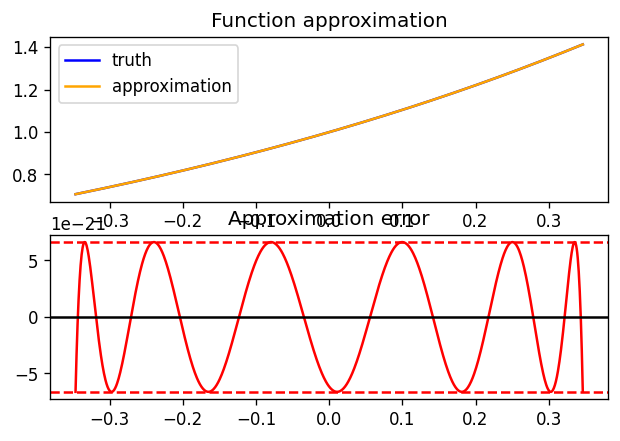

In [22]:
# Use very high precision to find the target rational function
mp.prec = 1000

p, q, h = approx(6, 7, 12)
plot(h)

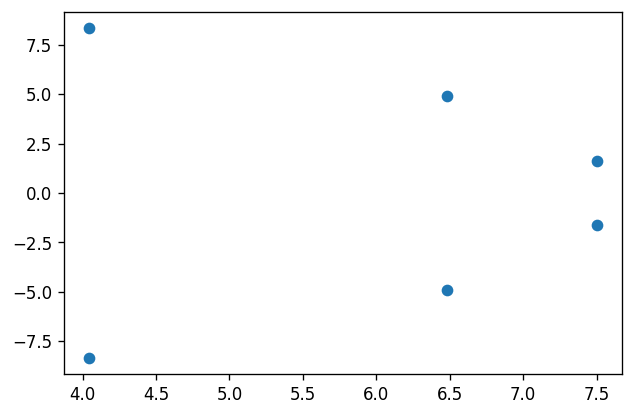

In [23]:
# Make sure the roots are not near the domain
plot_roots(q)

In [24]:
# Rescale so q[-1] is 1
pr = [pi / q[-1] for pi in p]
qr = [qi / q[-1] for qi in q]

In [25]:
# Factor out scale s so p[-1] is 1
ps = [pi / pr[-1] for pi in pr]
s = pr[-1]

In [26]:
# Print closest representable numbers
def represent(x, base = 2**96):
    n = int(mp.nint(x * base))
    #if n < 0:
    #    n += 2**256
    # assert n >= 0 and n < 2**256
    return n

for i, pi in enumerate(reversed(ps)):
    print(f'p{len(pr) - i - 1} = {represent(pi)} // {float(pi)}')
print()

for i, qi in enumerate(reversed(qr)):
    print(f'q{len(qr) - i - 1} = {represent(qi)} // {float(qi)}')
print()

print(f's = {represent(s)} // {float(s)}')


p5 = 79228162514264337593543950336 // 1.0
p4 = 2772001395605857295435445496992 // 34.987576483384714
p3 = 44335888930127919016834873520032 // 559.5975916031831
p2 = 398888492587501845352592340339721 // 5034.680597517145
p1 = 1993839819670624470859228494792842 // 25165.796560177085
p0 = 4385272521454847904632057985693276 // 55349.9208146512

q6 = 79228162514264337593543950336 // 1.0
q5 = -2855989394907223263936484059900 // -36.04765406988995
q4 = 50020603652535783019961831881945 // 631.3487788326532
q3 = -533845033583426703283633433725380 // -6738.071623045815
q2 = 3604857256930695427073651918091429 // 45499.69534231811
q1 = -14423608567350463180887372962807573 // -182051.53457589805
q0 = 26449188498355588339934803723976023 // 333835.6924987834

s = 477854134370404556630342282363 // 6.031367120048645


In [27]:
for i in reversed(range(6)):
    e = -2**i
    print(f'{e}, {represent(e)}, {represent(mp.exp(mp.mpf(e)))}')

-32, -2535301200456458802993406410752, 1003358566231181
-16, -1267650600228229401496703205376, 8915955111228592727647
-8, -633825300114114700748351602688, 26578087600922394298733672
-4, -316912650057057350374175801344, 1451114414429211511965335629
-2, -158456325028528675187087900672, 10722365814184344471345157570
-1, -79228162514264337593543950336, 29146412150787779157341161347


In [28]:
def eval_poly(c, x):
    r = c[-1]
    for c in reversed(c[:-1]):
        # print(represent(r))
        r = r * x + c
    return r

In [29]:
def range_reduce(x):
    k = mp.nint(x / mp.log(2))
    k = mp.floor(x / mp.log(2) + 0.5)
    r = x - k * mp.log(2)
    assert r >= start and r <= stop
    return r, k

In [30]:
x = linspace(-42, 135, 10000)
#x = linspace(-5, 5, 10000)
r = [range_reduce(x)[0] for x in x]
k = [range_reduce(x)[1] for x in x]

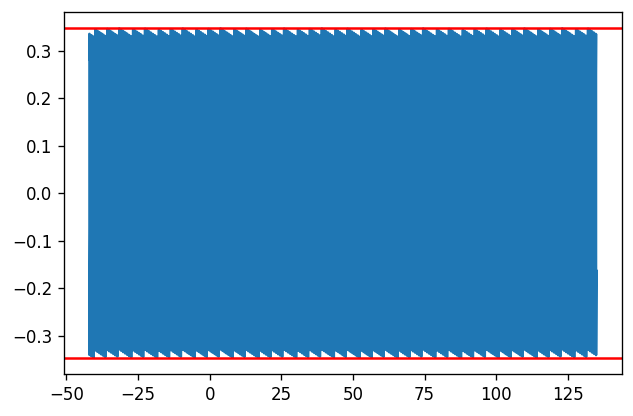

In [31]:
plt.plot(x, r)
plt.axhline(start, color='red')
plt.axhline(stop, color='red')

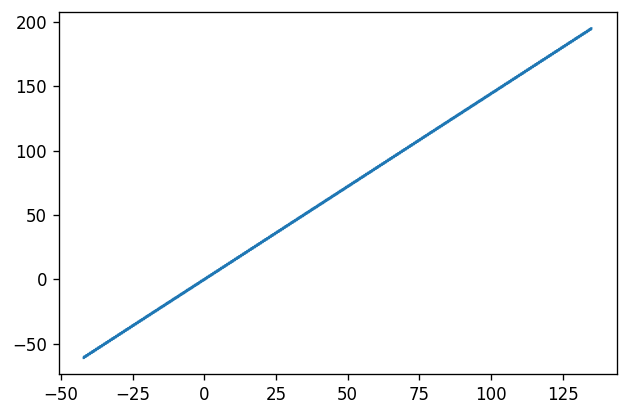

In [32]:
plt.plot(x, k)

In [33]:
mp.exp(start), mp.exp(stop)

(mpf('0.70710678118654752440084436210484903928483593768847403658833986899536623923105351942519376716382078636750692311545614851246241802792536860632206074854996791570661133296375279637789997525057639103028573505477998580298513726729843100736425870932044459930477616461524215435716072541988130181399762570399482'),
 mpf('1.41421356237309504880168872420969807856967187537694807317667973799073247846210703885038753432764157273501384623091229702492483605585073721264412149709993583141322266592750559275579995050115278206057147010955997160597027453459686201472851741864088919860955232923048430871432145083976260362799525140798964'))

In [34]:
96 + 196

292

In [35]:
mp.log(1.5 * 3814697265625 * 2**96) / mp.log(2)

mpf('138.379668208693678443119488674756839674326779482134932077441367779227924206749612447824795855386751033884813353259563700226551298157804408811097533864597495388828781940073685470015899501723195735311923852419813810709099435437346832840608230171985588941085674872502148222277991648605109967469376996817907')

In [36]:
256 - 139

117

In [37]:
mp.floor(mp.log((mp.mpf(2**255) - 1) / 1e18) * 1e18)

mpf('135305999368893231589.0')

In [38]:
mp.exp(mp.mpf(135305999368893231589) / 1e18) * 1e18 / 2**255

mpf('0.999999999999999999929655212483530877569766728018192362869417686818051178017752597128368320424192249784395744044680814630248294964763511770920471528650608178598336790245265191580484952312620943338241976905928102216036830074426834523270259530716635472238779114158360449930139768335757820081157697843599995')

In [39]:
57896044618658097649809650851135836446708721278684416180224000000000000000000 / 1e18

5.78960446186581e+58

In [40]:
mp.exp(mp.mpf(135305999368893231588) / 1e18) - 57896044618658097649809650851135836446708721278684416180224000000000000000000 / 1e18

mpf('-4203992104768750933177207628066772048716376.03758954491510690806025367038828226400615489325675158678787492058150995687982700561708072814617255365012456226238539983027868771731481569268382369587111070171523042515049107353970975278521261359345889650565804089519220012041164923538713278294176411002229243313')

In [41]:
117 + 78

195

In [42]:
5**18 / 2**78

1.2621774483536189e-11

In [43]:
1104 - 721

383

In [44]:
1604 - 1104

500

In [45]:
135305999368893231589 / 1e18

135.30599936889323

In [46]:
1557 - 1101

456

In [47]:
2013 - 1557

456

In [48]:
477854134370404556630342282363 / 2**96

6.031367120048645

In [49]:
477854134370404556630342282363 * 5**18 * 2**21

3822833074963236453042738258904000000000000000000

In [50]:
represent(s * 5**18 * 2**21)

3822833074963236453042738258902158003155416615667

In [51]:
s

mpf('6.03136712004864557952315856198929863614111669874514109730927255939775680189403952220316710517480306071594208850188477877556735820804525198969457536138443146546121200321637431614490926955571913002360587339935400415355775801290915954341637830662850520033777442238469479074206810293790783703899105664307627')

In [52]:
0.6/s

mpf('0.0994799334972600239893273185070413787335074214738769293354171471956504620526585596986367195163103066279063471406432600230139165007154885810944805265755928219843064326354566914276197210894307756242053606209666678736437204963128430904580314889774733079922160401934185474798117148195527088036031325044432472')

In [53]:
1.5/s

mpf('0.248699833743150069177061017670724671979300081715420282379222122103761857021323047513692562854944835063364612722940710747049408285683428782806373677021051744231880843861395251251836076661195759287526020891650385091147506412245385389313916662857437054747853228989516913562217655401488664162872716506454342')

In [54]:
117 + 78

195

In [55]:
mp.log(2**96)/mp.log(10)

mpf('28.898879583742194740518933893551330569746228620362419965801036268202386170344752910745016203345872515905709810377375556393097716588818256575970464035650775206192284568402566655534694493913882576113654678225143931246826195058745188449972931153942973841562796403878425278009083661969201342555136577662302')

In [56]:
2**96

79228162514264337593543950336

In [57]:
10**28

10000000000000000000000000000

In [58]:
-146734746076776222436 / 1e18

-146.73474607677622

In [59]:
11723370297369374509729453784 / 2**96

0.14796973608038283

In [60]:
2**7 * mp.exp(11723370297369374509729453784 / 2**96)

mpf('148.413159102576602797754083563570111419653820541465285237666042237698759889625988360891040035965826369113610383319083172246154719918203608319123322448591962360409021343976357096610477205469832985887818694692235881954573458875421906196628354792740184032576721445531220311788045498028288403446882565129333')

In [61]:
15230924295686815968900942473 / 2**96

0.19224129163597126

In [62]:
15230924295686815968900942473 * 3822833074963236453042738258902158003155416615667

58225281159812697126805713314171885814935114840302346943497197419720317524491

In [63]:
(15230924295686815968900942473 * 3822833074963236453042738258902158003155416615667) / 2**255

1.0056866845278147

In [64]:
3822833074963236453042738258902158003155416615667 // 2

1911416537481618226521369129451079001577708307833

In [65]:
116+78

194

In [66]:
int(mp.nint(mp.exp(5) *1e18))

148413159102576603421

## Knuth explicit formula for 7-term polynomial q

In [67]:
def alpha(u, root=0):
    b = [mp.mpf(0)] * 9
    b[1] = (u[5] - 1) / 2
    b[2] = u[4] - b[1] * (b[1] + 1)
    b[3] = u[3] - b[1] * b[2]
    b[4] = b[1] - b[2]
    b[5] = u[2] - b[1] * b[3]
    
    coeff = [
        u[1] - b[2] * b[5],
        2 * b[5] - b[2] * b[4] - b[3],
        2 * b[4] - b[2] + 1,
        mp.mpf(2)
    ]
    roots = mp.polyroots(list(reversed(coeff)), extraprec=100)
    b[6] = roots[root]
    
    b[7] = b[6]**2 + b[4] * b[6] + b[5]
    b[8] = b[3] - b[6] - b[7]
    
    a = [mp.mpf(0)] * 6
    a[0] = b[2] - 2 * b[6]
    a[2] = b[1] - a[0]
    a[1] = b[6] - a[0] * a[2]
    a[3] = b[7] - a[1] * a[2]
    a[4] = b[8] - b[7] - a[1]
    a[5] = u[0] - b[7] * b[8]
    
    return a

In [68]:
def eval_knuth(a, x):
    print(represent(x))
    z = (x + a[0]) * x + a[1]
    print(represent(z))
    w = (x + a[2]) * z + a[3]
    print(represent(w))
    u = (w + z + a[4]) * w + a[5]
    print(represent(u))
    return u

In [69]:
# Knuth's example
alpha([mp.mpf(x) for x in [3, -37, -61, 33, 49, 13, 1]], root=1)

[mpf('3.0'), mpf('-7.0'), mpf('3.0'), mpf('16.0'), mpf('6.0'), mpf('-27.0')]

In [70]:
qa = alpha(qr)

In [71]:
eval_knuth(qa, mp.mpf(10)), eval_poly(qr, mp.mpf(10))

792281625142643375935439503360
48216574280656016718393701190044
25197191960878039318086292520920
2689054483393637354306695345160938


(mpf('33940.6392633364003325682591863775752607548877694584357065028225429751234565231771220428887816390463416994077120539647912124225385434116695253366237435058847036677648591715548293619916304689748921014894659373932711714429029088930502157727678743432927419922767834626946515301627986457193588184253788470536'),
 mpf('33940.6392633364003325682591863775752607548877694584357065028225429751234565231771220428887816390463416994077120539647912124225385434116695253366237435058847036677648591715548293619916304689748921014894659373932711714429029088930502157727678743432927419922767834626946515301627986457193588184253788470414'))

In [72]:
for i, a in enumerate(qa):
    print(f'a_{i} = {represent(a)}')

a_0 = 750530180792738023273180420736
a_1 = 32788456221302202726307501949080
a_2 = -2218138959503481824038194425854
a_3 = 892943633302991980437332862907700
a_4 = -78174809823045304726920794422040
a_5 = 4203224763890128580604056984195872


In [73]:
11723370297369374509729453784 / 2**96

0.14796973608038283

In [74]:
eval_knuth(qa, mp.mpf(11723370297369374509729453784) / 2**96)

11723370297369374509729453784
32901246678083340530892776720321
-23319236756237536982852715105152
24392153673876097338736908011219514


mpf('307872.262839422830813564365857993041028569798668906680515254072111391286606501248870641361710735079668993993981358383107558187381280616570252651936880082711960105603047126881730279378250476918573439856447168020088340568526447960481495475414067089415987250335058246330910296857624352215439997449188695355')

## Knuth explicit formula for 6-term polynomial p

In [75]:
ps

[mpf('55349.9208146512037099932492742768790032776866251732540539497786874794377327112267517246827759200494752549050144458012707920185168382286789810324801386514069539980983201355037337619406829024703788717470573249061862863808743590268693220557705537079009231940456358548388318839648779328721678093130206491165'),
 mpf('25165.7965601770841639097143382802041702991350645376057038734792704624136972006971124896753649347501815815465126835316186027005678801158323009278269868797444888605900886136213760307622717383144510386411447006324880711863649114697299595430945155892448180809189720265976954102437249274537231945197209889597'),
 mpf('5034.6805975171450130998836438325313038403524914336110563718752383657915261450399558661420599289386669314751272185460480417993591652961513742310013740109465478849874087939030371073591710239379595643953133184713957043034904489121343725089848133576960717874302501866678525575080921085760118113177398646306'),
 mpf('559.5975916031831490938961722098581095060975651118461

In [76]:
def alpha(u):
    u0 = u[0]
    u = u[1:]
    
    a = [mp.mpf(0)] * 5
    a[0] = (u[3] - 1) / 2
    b = u[2] - a[0] * (a[0] + 1)
    a[1] = u[1] - a[0] * b
    a[2] = b - 2 * a[1]
    a[3] = u[0] - a[1] * (a[1] + a[2])
    a[4] = u0
    
    return a

In [77]:
def eval_knuth(a, x):
    y = (x + a[0]) * x + a[1]
    u = y + x + a[2]
    u = u * y + a[3]
    u = u * x + a[4]
    return u

In [78]:
pa = alpha(ps)

In [79]:
for i, a in enumerate(pa):
    print(f'a_{i} = {represent(a)}')

a_0 = 1346386616545796478920950773328
a_1 = 57155421227552351082224309758442
a_2 = -94201549194550492254356042504812
a_3 = 28719021644029726153956944680412240
a_4 = 4385272521454847904632057985693276


In [80]:
eval_knuth(pa, mp.mpf(10)), eval_poly(ps, mp.mpf(10))

(mpf('1819949.30260516683854093327338562245401478053020435462193654361555063609192284055008224936262172481465961871467154129946029162762259821955700911182340414572039133311670278268175247051326525836979051582010118394346252856744821912105370790030307658777673720565262946170504856655998325317493910774494222091'),
 mpf('1819949.30260516683854093327338562245401478053020435462193654361555063609192284055008224936262172481465961871467154129946029162762259821955700911182340414572039133311670278268175247051326525836979051582010118394346252856744821912105370790030307658777673720565262946170504856655998325317493910774494222032'))